In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from preprocessing import ReviewPreprocessor
from embeddings import EmbeddingsManager

from sentiments import (
    sentimentCache_init,
    sentiment_parseScore,
)

embeddingManager: EmbeddingsManager = None

# Data are stored into a directory named after the topic and the seed.
# e.g., if seed is 1967 and the topic is "general", the directory will be "general/1967"
seed = 1967
file_path = "digital_music.jsonl"
topicGeneral = os.path.splitext(os.path.basename(file_path))[0]
if not os.path.exists(topicGeneral):
    os.makedirs(topicGeneral)
topicAndSeed = os.path.join(topicGeneral, str(seed))
if not os.path.exists(topicAndSeed):
    os.makedirs(topicAndSeed)
# Set cache files (shared amongst the modules)
sentiments_cache_file = os.path.join(topicAndSeed, f"{topicGeneral}_sentiments_cache.json")
embeddings_cache_file = os.path.join(topicGeneral, f"{topicGeneral}_embeddings_cache.pkl")
preprocessing_cache_prefix = os.path.join(topicGeneral, topicGeneral)
# Set result file (CSV format, containing original and adjusted ratings)
result_file = os.path.join(topicGeneral, f"{topicGeneral}_results.csv")

# Initialize embeddings cache
embeddingManager = EmbeddingsManager(
    embeddings_cache_file=embeddings_cache_file,
)

# Initialize sentiment cache
sentimentCache_init(sentiments_cache_file)
# Instantiate the ReviewPreprocessor class (which now handles cache initialization)
preprocessor = ReviewPreprocessor(preprocessing_cache_prefix)

In [2]:
label_text = "text"
label_rating = "rating"
reviewsToProcess: int = 100


In [3]:

# Load a random sample of reviews from the file.
original_reviews, original_indices = preprocessor.LoadReviews(
    file_path, reviewsToProcess, label_text, label_rating, seed
)
print(f"\nLoaded {len(original_reviews)} reviews.")


Loaded 100 reviews.


In [4]:

print("Preprocessing reviews...")
# Build a dict mapping review text to its rating (this is useful for caching).
reviews_dict: dict[str, float] = {
    str(review[label_text]): review[label_rating] for review in original_reviews
}
# Call the class method on the preprocessor instance.
preprocessed_reviews = preprocessor.PreprocessReviews(reviews_dict)

Preprocessing reviews...


In [5]:
# Define the analyze_sentiment function
def analyze_sentiment(pairs):
    """
    Analyze sentiment for a list of pairs.
    Returns a dictionary with sentiment scores for each pair.
    """
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = {}
    for noun, adj in pairs:
        phrase = f"{adj} {noun}"
        score = sid.polarity_scores(phrase)
        sentiment_scores[phrase] = score
    return sentiment_scores

In [6]:
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Create a dict that for each review contains its sentences and 
# for each sentence the adjectives and nouns found in it.
reviews_dict: dict[str, list[dict]] = {}


In [ ]:
# Extract adjective-noun pairs
pairs: list[tuple[str, str]] = []
nouns: list[str] = []

review_dict: dict[list[tuple[str, str]], list[str]] = {}

for item in preprocessed_reviews.values():

    review = item["corrected"]
    # split sentences on hard punctuation (periods, exclamation marks, question marks)
    import re
    sentences = re.split(r'(?<=[.!?]) +', review)
    pairs = []
    nouns = []
    for sentence in sentences:
        sentence = sentence.strip()
        if len(sentence) < 4:
            continue
        # Process the sentence with SpaCy
        doc = nlp(sentence)
        for token in doc:
            if token.pos_ == "NOUN":
                for child in token.children:
                    if child.dep_ == "amod":
                        pairs.append((token.text, child.text))
                        nouns.append(token.text)
            # Additional check for adjectival complements (e.g., "the product is good")
            if token.dep_ == "acomp":
                # Find the subject from the token's head.
                subjects = [child for child in token.head.children if child.dep_ == "nsubj"]
                if subjects:
                    pairs.append((subjects[0].text, token.text))
                    nouns.append(subjects[0].text)

        nouns = sorted(list(set(nouns)))
        reviews_dict[review] = {"nouns": nouns, "pairs": pairs}
    # Add the pairs to the preprocessing cache. The sentiment score
    # is not yet calculated.
    preprocessor.AddSubitemsToReviewCache(review, {"pairs": pairs})
    preprocessor.AddSubitemsToReviewCache(review, {"nouns": nouns})

# Print the results
if 0:
    for review, items in reviews_dict.items():
        print(f"Review: {review[:64]}")
        print(f"\tNouns: {items['nouns']}")
        print(f"\tPairs: {items['pairs']}")


In [ ]:

# Modified cell: now storing filtered reviews into a new dict called filtered_reviews_dict
filtered_reviews_dict: dict[str, list[dict]] = {}

for review, review_data in reviews_dict.items():
    pairs = review_data["pairs"]
    # Calculate the sentiment scores for the pairs
    sentiment_scores = analyze_sentiment(pairs)
    # Print the sentiment scores for each pair
    for pair, score in sentiment_scores.items():
        print(f"\t{pair}: {score}")
    # Filter out pairs with a compound score below 0.1
    filtered_pairs = [(pair.split()[0], pair.split()[1]) 
                    for pair, score in sentiment_scores.items() if abs(score['compound']) >= 0.05]
    # Skip if no pair meets the criteria
    if not filtered_pairs:
        continue
    # Calculate the average compound score for the filtered pairs
    avg_score = np.mean([score['compound'] for score in sentiment_scores.values()])
    # Create a new item with filtered data
    new_item = review_data.copy()
    new_item["pairs"] = filtered_pairs
    new_item["nouns"] = sorted(list(set([noun for _, noun in filtered_pairs])))
    new_item["score"] = avg_score
    new_item["VADER"] = sid.polarity_scores(review)["compound"]
    filtered_reviews_dict[review] = [new_item]
    # update the cache with the filtered pairs and nouns
    preprocessor.AddSubitemsToReviewCache(review, {"pairs": filtered_pairs})
    preprocessor.AddSubitemsToReviewCache(review, {"nouns": new_item["nouns"]})

# Print the filtered results from the new dictionary
if 0:
    for review, items in filtered_reviews_dict.items():
        print(f"Review: {review[:32]}...")
        for item in items:
            print(f"\tNouns: {item['nouns']}")
            print(f"\tPairs: {item['pairs']}")
            print(f"\tScore: {item['score']:.2f}")
            print(f" (VADER: {item['VADER']:.2f})")


	great shakes: {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
	little game: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	strong heart: {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.5106}
	friendly heart: {'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'compound': 0.4939}
	powerful heart: {'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
	long story: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	short story: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	secret heart: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	several tunes: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	bobby field: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	longtime collaborators: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	different versions: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
	better they: {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}
	instrumental ala: {'neg': 0.0, 'neu': 1.0, 'pos': 0.

In [14]:

# Create a dictionary to store the results
parsed_scores = {}

# Iterate through each review in the filtered_reviews_dict
for review, items in filtered_reviews_dict.items():
    # Extract the list of nouns for the review
    nouns = [noun for item in items for noun in item["nouns"]]
    # Invoke sentiment_parseScore() and store the result in the dictionary
    parsed_scores[review] = sentiment_parseScore(review, nouns)

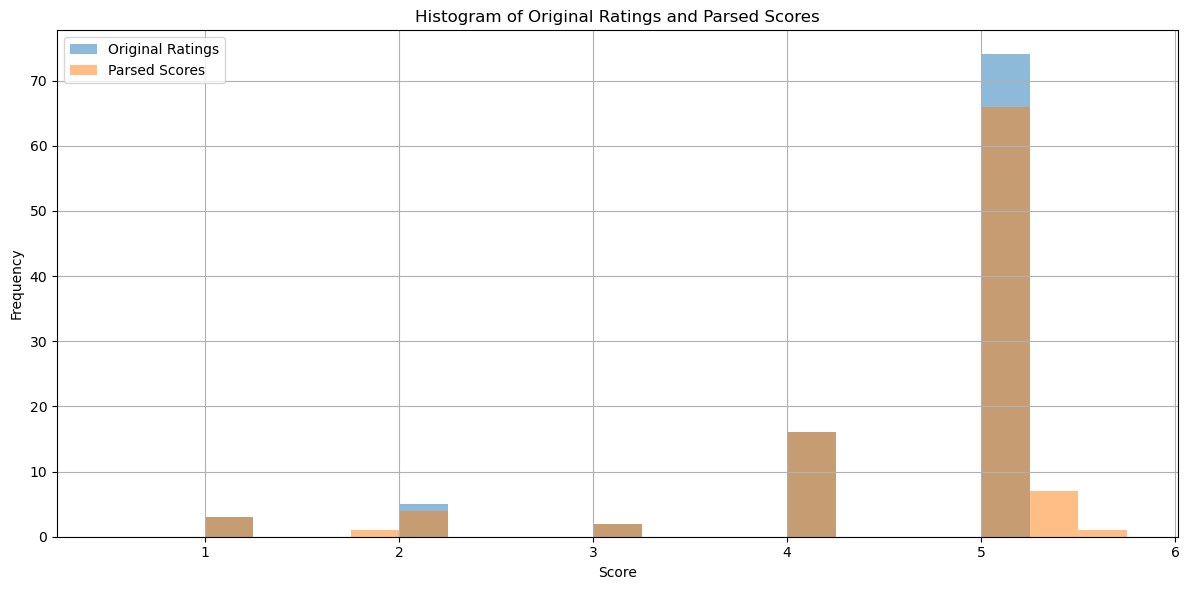

In [22]:
# Extract original ratings and parsed scores
original_ratings = [review["score"] for review in preprocessed_reviews.values()]

# Ensure parsed_scores keys match preprocessed_reviews keys
parsed_avg_scores = [
    original_ratings[idx] + np.sum(list(parsed_scores.get(review, {}).values())) * 0.25
    for idx, review in enumerate(preprocessed_reviews.keys())
]

# Adjust bins to be centered on the numbers
bins = np.arange(min(original_ratings + parsed_avg_scores) -0.5 , max(original_ratings + parsed_avg_scores) + 0.5, 0.25)

# Plot the histograms
plt.figure(figsize=(12, 6))

# Histogram for original ratings
plt.hist(original_ratings, bins=bins, alpha=0.5, label='Original Ratings')

# Histogram for parsed average scores
plt.hist(parsed_avg_scores, bins=bins, alpha=0.5, label='Parsed Scores')

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Original Ratings and Parsed Scores')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import random
import csv

random.seed(seed)  # Set the seed for reproducibility
sample_reviews = random.sample(list(preprocessed_reviews.keys()), 100)

# Percorsi dei file
reviews_file = os.path.join(topicAndSeed, "sample_reviews.txt")
csv_file = os.path.join(topicAndSeed, "sample_reviews.csv")

# Scrivi il file con solo le recensioni
with open(reviews_file, "w", encoding="utf-8") as f:
    for review in sample_reviews:
        f.write(review.replace('\n','') + "\n")

# Scrivi il file ECSV con recensioni, voto originale e voto modificato
with open(csv_file, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["review", "original_rating", "adjusted_rating"])  # Header ECSV
    for review in sample_reviews:
        original_rating = int(preprocessed_reviews[review]["score"]*100)
        adjusted_rating = int(np.sum(list(parsed_scores.get(review, {}).values()))*100)
        writer.writerow([review, original_rating, adjusted_rating])

In [ ]:
import sentiments

grades: dict[str, int] = {}
for review in sample_reviews:
    grades[review] = sentiments.assignGradeToReview(review)

with open(os.path.join(topicAndSeed, "grades.txt"), "w", encoding="utf-8") as f:
    for review, grade in grades.items():
        f.write(f"{review}: {grade}\n")

In [11]:
# Now we can calculate the average sentiment for each review.
# For comparison, we can also calculate directly the sentient of the review using VADER.

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

for review, items in reviews_dict.items():
    # Calculate the average sentiment for the review
    avg_sentiment = np.mean([item["score"] for item in items])
    # Calculate the overall sentiment of the review using VADER
    vader_score = sid.polarity_scores(review)["compound"]
    # Store the results in the review dictionary
    reviews_dict[review].append({"avg_sentiment": avg_sentiment, "vader_score": vader_score})
# Print the results 
for review, items in reviews_dict.items():
    print(f"Review: {review[:32]}")
    for item in items:
        if "avg_sentiment" in item:
            print(f"\tAverage Sentiment: {item['avg_sentiment']}")
            print(f"\tVADER Score: {item['vader_score']}")
        else:
            print(f"\tSentence: {item['sentence'][:32]}")
            print(f"\t\tNouns: {item['nouns']}")
            print(f"\t\tPairs: {item['pairs']}")






TypeError: string indices must be integers, not 'str'

In [ ]:
# prepare a list with only nouns, it will be passed to the LLM
for element in pairs:
    if element[0] not in nouns:
        nouns.append(element[0])
nouns = sorted(nouns)

# now pass the list to the preprocessor. Remember that the
# preprocessor expects a dict with the text as key and the rating as value.
nouns_dict: dict[str, float] = {noun: 0.0 for noun in nouns}
preprocessed_nouns = sorted(list(preprocessor.preprocess_reviews(nouns_dict).keys()))


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

scores: dict[str, float, float] = {}

original_reviews = [
    "decent", "good", "bad", "excellent", "terrible",
    "awful", "great", "poor", "average", "fantastic",
    "bombastic", "incredible", "mediocre", "wonderful", "horrible",
]
sid = SentimentIntensityAnalyzer()

for review in original_reviews:
#    review[label_text] = review[label_text].replace("\n", " ").replace("\r", " ").replace("\t", " ")
    averagedPositive: float = 0.0
    averagedNegative: float = 0.0
    counter: int = 0
    for sentence in review.split("."):
#    for sentence in review[label_text].split("."):
        sentence = sentence + " purchase"
        if len(sentence) > 0:
            # Use the SentimentIntensityAnalyzer to get the sentiment scores
            sentiment_scores = sid.polarity_scores(sentence)
            # Print the sentiment scores for each sentence
#            print(f"Sentiment Scores: {sentiment_scores}")
            averagedPositive += sentiment_scores["pos"]
            averagedNegative += sentiment_scores["neg"]
            counter += 1
    if counter > 0:
        averagedPositive /= counter
        averagedNegative /= counter
    # Print the averaged positive score for the review
    print(f"Term {review}: {sentiment_scores}")
#    adjusted_rating = round(review[label_rating] + averagedPositive - averagedNegative, 1)

#    scores[review[label_text]] = (review[label_rating], adjusted_rating)


Term decent: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Term good: {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}
Term bad: {'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'compound': -0.5423}
Term excellent: {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
Term terrible: {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
Term awful: {'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.4588}
Term great: {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
Term poor: {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
Term average: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Term fantastic: {'neg': 0.0, 'neu': 0.217, 'pos': 0.783, 'compound': 0.5574}
Term bombastic: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Term incredible: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Term mediocre: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Term wonderful: {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'comp

In [ ]:
# Now plot the results
originals: list[float] = []
adjusted: list[float] = []
for review in original_reviews:
    originals.append(review[label_rating])
    adjusted.append(scores[review[label_text]][1])


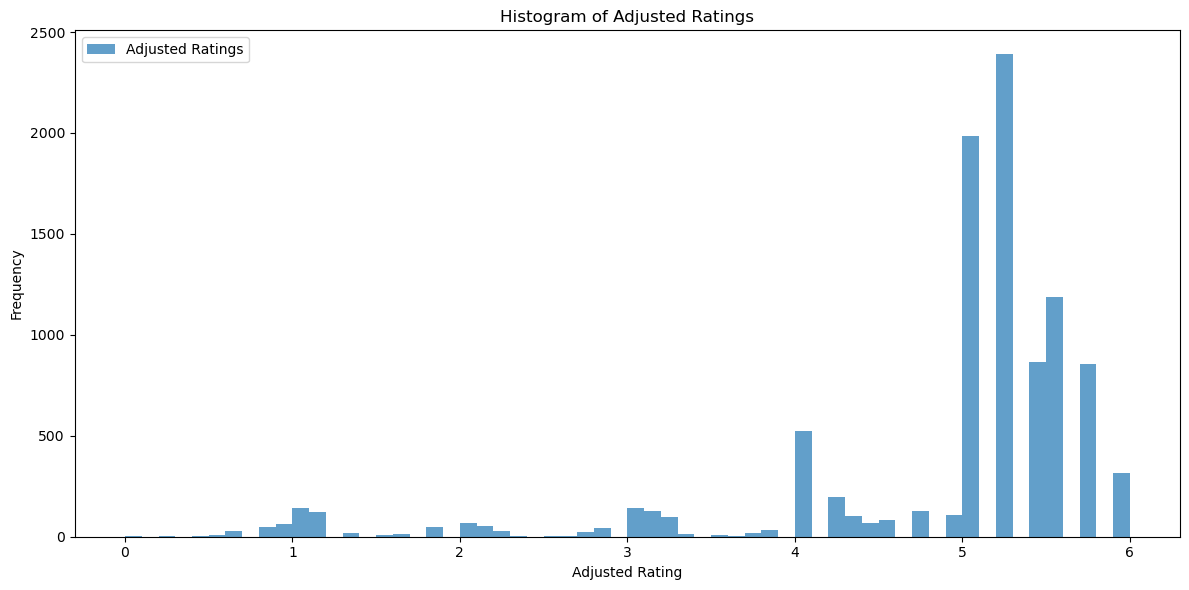

In [ ]:
# plot the distribution of the adjusted ratings with a more granular binning
plt.figure(figsize=(12, 6))
# Create bins for adjusted ratings with a smaller width
adjusted_bins = np.arange(min(adjusted), max(adjusted) + 0.1, 0.1)
# Calculate histogram data for adjusted ratings
counts_adj, bin_edges = np.histogram(adjusted, bins=adjusted_bins)
# Compute the bin centers for adjusted ratings
bin_centers_adj = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot the adjusted ratings histogram with a smaller width
plt.bar(bin_centers_adj, counts_adj, width=0.1, alpha=0.7, label='Adjusted Ratings')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted Ratings')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# now save 100 random sentences of the sample in a file called "sentences.txt", with no ratings
sentences_file = os.path.join(topicAndSeed, "sentences.txt")
if os.path.exists(sentences_file):
    os.remove(sentences_file)
with open(sentences_file, "w") as f:
    for review in original_reviews:
        sentences = review[label_text].split(".")
        for sentence in sentences:
            if len(sentence) > 0:
                f.write(sentence.strip() + "\n")